In [8]:
import pandas as pd
from math import radians, cos, sin, sqrt, atan2

# CSV laden mit expliziter Umwandlung
df = pd.read_csv("202408-bluebikes-tripdata.csv", sep=';', dtype=str)

# Zeitspalten
df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

# Float-Spalten (Koordinaten)
float_cols = ["start_lat", "start_lng", "end_lat", "end_lng"]
for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Dauer in Minuten
df["duration_min"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60

# Ungültige Zeilen entfernen
df = df.dropna(subset=["duration_min", "start_lat", "start_lng", "end_lat", "end_lng", "started_at", "ended_at"])


In [9]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Erdradius in km
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi / 2)**2 + cos(phi1) * cos(phi2) * sin(dlambda / 2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Distanz berechnen
df["trip_distance_km"] = df.apply(
    lambda r: haversine(r["start_lat"], r["start_lng"], r["end_lat"], r["end_lng"]),
    axis=1
)


In [10]:
df["hour"] = df["started_at"].dt.hour
df["dayofweek"] = df["started_at"].dt.dayofweek
df["month"] = df["started_at"].dt.month
df["is_weekend"] = df["dayofweek"] >= 5


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Zielvariable
y = df["duration_min"]

# Features (Kontrolliert auf Spaltennamen!)
X = df[["start_station_name", "end_station_name", "hour", "dayofweek", "month", "is_weekend", "trip_distance_km"]]

# Vorverarbeitung
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["start_station_name", "end_station_name"]),
    ("num", "passthrough", ["hour", "dayofweek", "month", "is_weekend", "trip_distance_km"])
])

# Pipeline mit Random Forest
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1, random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trainieren
model.fit(X_train, y_train)

# Vorhersage
y_pred = model.predict(X_test)

# RMSE
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ RMSE: {rmse:.2f} Minuten")


✅ RMSE: 22.87 Minuten


In [14]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1) CSV mit korrektem Trennzeichen einlesen
df = pd.read_csv("202408-bluebikes-tripdata.csv", sep=";")

# 2) Datum extrahieren
df['date'] = pd.to_datetime(df['started_at'], format="%d.%m.%Y %H:%M", errors='coerce').dt.date

# 3) Aggregation: Fahrten pro Station und Tag zählen
daily_counts = (
    df.groupby(['start_station_name', 'date'])
      .size()
      .reset_index(name='num_rides')
)

# 4) Zusätzliche Zeit-Features
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
daily_counts['dayofweek'] = daily_counts['date'].dt.dayofweek
daily_counts['month'] = daily_counts['date'].dt.month
daily_counts['is_weekend'] = (daily_counts['dayofweek'] >= 5).astype(int)

# 5) Features und Ziel definieren
X = daily_counts[['start_station_name', 'dayofweek', 'month', 'is_weekend']]
y = daily_counts['num_rides']

# 6) Preprocessing & Pipeline aufsetzen
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['start_station_name']),
    ('num', 'passthrough', ['dayofweek', 'month', 'is_weekend'])
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# 7) Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8) Modell trainieren
pipeline.fit(X_train, y_train)

# 9) Vorhersage
y_pred = pipeline.predict(X_test)

# 10) RMSE manuell berechnen (kein squared=False)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)

print(f"✅ RMSE: {rmse:.2f} Fahrten pro Station/Tag")


✅ RMSE: 12.62 Fahrten pro Station/Tag


RMSE (auf allen Daten): 8.78 Fahrten/Tag


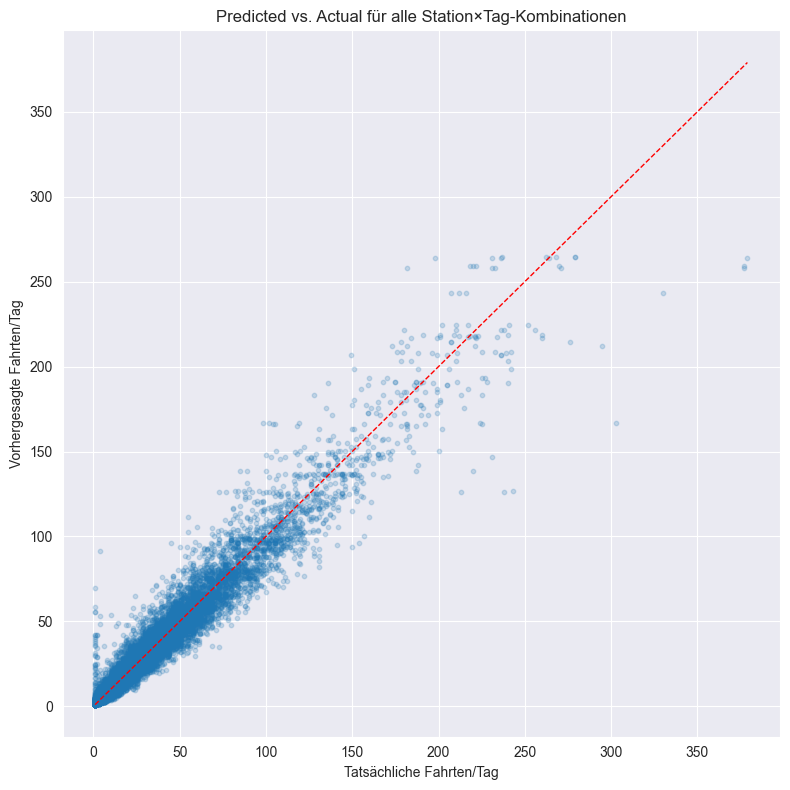

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from math import sqrt
from sklearn.metrics import mean_squared_error

# 1) Daten laden & Datum extrahieren
df = pd.read_csv("202408-bluebikes-tripdata.csv", sep=";")
df['date'] = pd.to_datetime(df['started_at'], format="%d.%m.%Y %H:%M", errors='coerce').dt.date

# 2) Aggregation: Fahrten pro Station und Tag
daily = (
    df.groupby(['start_station_name', 'date'])
      .size()
      .reset_index(name='num_rides')
)

# 3) Features bauen
daily['dayofweek']  = pd.to_datetime(daily['date']).dt.dayofweek
daily['month']      = pd.to_datetime(daily['date']).dt.month
daily['is_weekend'] = (daily['dayofweek'] >= 5).astype(int)

# 4) X und y für **alle** Einträge
X_all = daily[['start_station_name','dayofweek','month','is_weekend']]
y_all = daily['num_rides']

# 5) Pipeline (OneHot + RandomForest)
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['start_station_name']),
    ('num', 'passthrough', ['dayofweek','month','is_weekend'])
])
model = Pipeline([
    ('prep', pre),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# 6) Auf **allen** Daten trainieren
model.fit(X_all, y_all)

# 7) Auf **allen** Daten vorhersagen
y_pred_all = model.predict(X_all)

# 8) RMSE auf **allen** Daten
mse_all = mean_squared_error(y_all, y_pred_all)
rmse_all = sqrt(mse_all)
print(f"RMSE (auf allen Daten): {rmse_all:.2f} Fahrten/Tag")

# 9) Scatterplot mit **allen** Punkten
plt.figure(figsize=(8,8))
plt.scatter(y_all, y_pred_all, alpha=0.2, s=10)
lims = [min(y_all.min(), y_pred_all.min()), max(y_all.max(), y_pred_all.max())]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlabel("Tatsächliche Fahrten/Tag")
plt.ylabel("Vorhergesagte Fahrten/Tag")
plt.title("Predicted vs. Actual für alle Station×Tag-Kombinationen")
plt.tight_layout()
plt.show()

